# STARBUCKS STOCK PRICE PREDICTION - LSTM - IMPLEMENTATION

In [2]:
import warnings
warnings.filterwarnings('ignore')

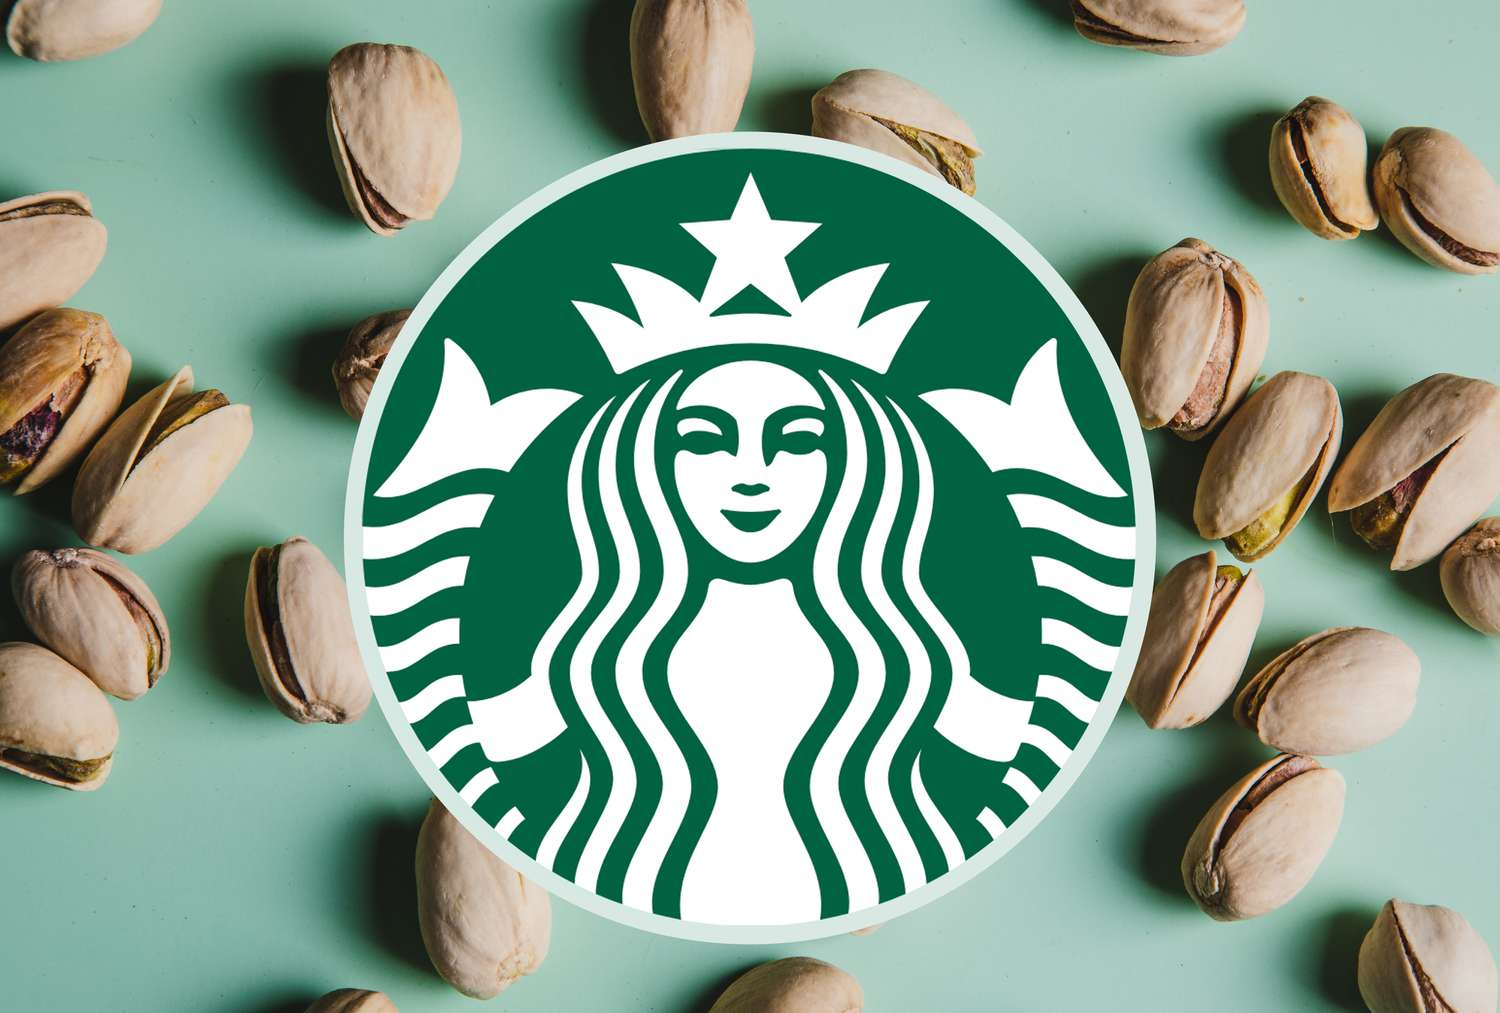

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [5]:
# Load Dataset
df = pd.read_csv('Starbucks_Stock_Data.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index()
print(f"Dataset shape: {df.shape}")

Dataset shape: (8376, 7)


In [39]:
df.head()

,Open,High,Low,Close,Volume,ticker,name
Date,,,,,,,
1992-06-26 00:00:00-04:00,0.246819,0.261510,0.240942,-0.861900,224358400,SBUX,Starbucks Corporation (SBUX) Historical Data
1992-06-29 00:00:00-04:00,0.255634,0.276202,0.249757,-0.861361,58732800,SBUX,Starbucks Corporation (SBUX) Historical Data
1992-06-30 00:00:00-04:00,0.276202,0.279141,0.258572,-0.861630,34777600,SBUX,Starbucks Corporation (SBUX) Historical Data
1992-07-01 00:00:00-04:00,0.264449,0.270325,0.255634,-0.861451,18316800,SBUX,Starbucks Corporation (SBUX) Historical Data
1992-07-02 00:00:00-04:00,0.270325,0.270325,0.261510,-0.861451,13996800,SBUX,Starbucks Corporation (SBUX) Historical Data


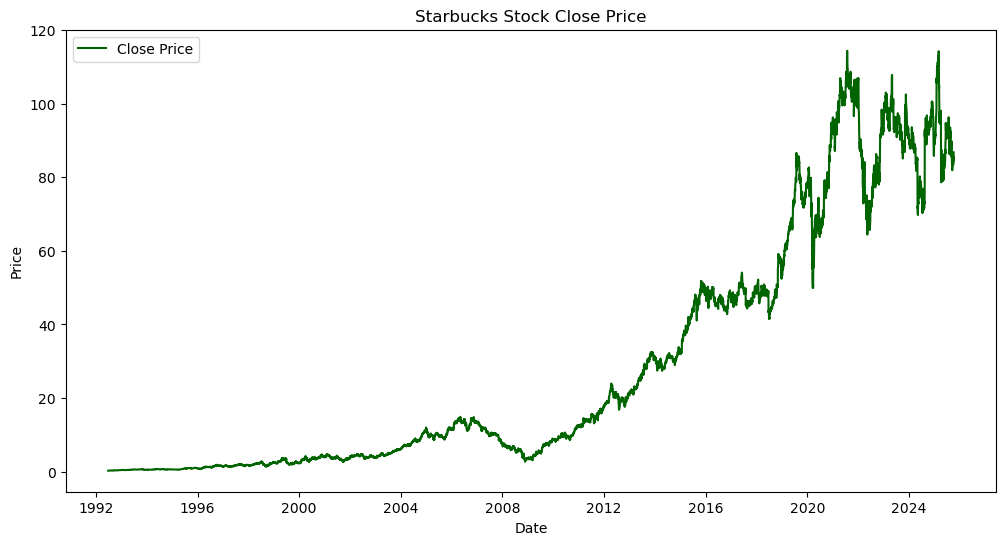

In [6]:
# Plot Closing Price
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Close Price', color='darkgreen')
plt.title('Starbucks Stock Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [7]:
# Scale Data
scaler = StandardScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

In [8]:
# Prepare Sequences
seq_length = 30
data = np.array([df.Close[i:i+seq_length] for i in range(len(df) - seq_length)])
data = data.reshape((data.shape[0], data.shape[1], 1))  # shape: (num_samples, seq_length, 1)

train_size = int(0.8 * len(data))
X_train = torch.from_numpy(data[:train_size, :-1, :]).float()
y_train = torch.from_numpy(data[:train_size, -1, :]).float()
X_test = torch.from_numpy(data[train_size:, :-1, :]).float()
y_test = torch.from_numpy(data[train_size:, -1, :]).float()

In [9]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: torch.Size([6676, 29, 1]), y_train: torch.Size([6676, 1])
X_test: torch.Size([1670, 29, 1]), y_test: torch.Size([1670, 1])


# Build the LSTM Model

In [11]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [12]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

# Train the Model

In [14]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 25 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

Epoch [25/200], Loss: 0.009497
Epoch [50/200], Loss: 0.001263
Epoch [75/200], Loss: 0.000365
Epoch [100/200], Loss: 0.000219
Epoch [125/200], Loss: 0.000199
Epoch [150/200], Loss: 0.000194
Epoch [175/200], Loss: 0.000190
Epoch [200/200], Loss: 0.000186


# Predict the Model

In [16]:
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train).cpu().numpy()
    y_train_real = y_train.cpu().numpy()
    y_test_pred = model(X_test).cpu().numpy()
    y_test_real = y_test.cpu().numpy()

In [17]:
# Inverse scale
y_train_pred = scaler.inverse_transform(y_train_pred)
y_train_real = scaler.inverse_transform(y_train_real)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_test_real = scaler.inverse_transform(y_test_real)

# Evaluate the Model

In [19]:
train_rmse = np.sqrt(mean_squared_error(y_train_real, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_real, y_test_pred))
print(f"Train RMSE: {train_rmse:.6f}")
print(f"Test RMSE: {test_rmse:.6f}")

Train RMSE: 0.446230
Test RMSE: 12.944891


# Plot the Predictions

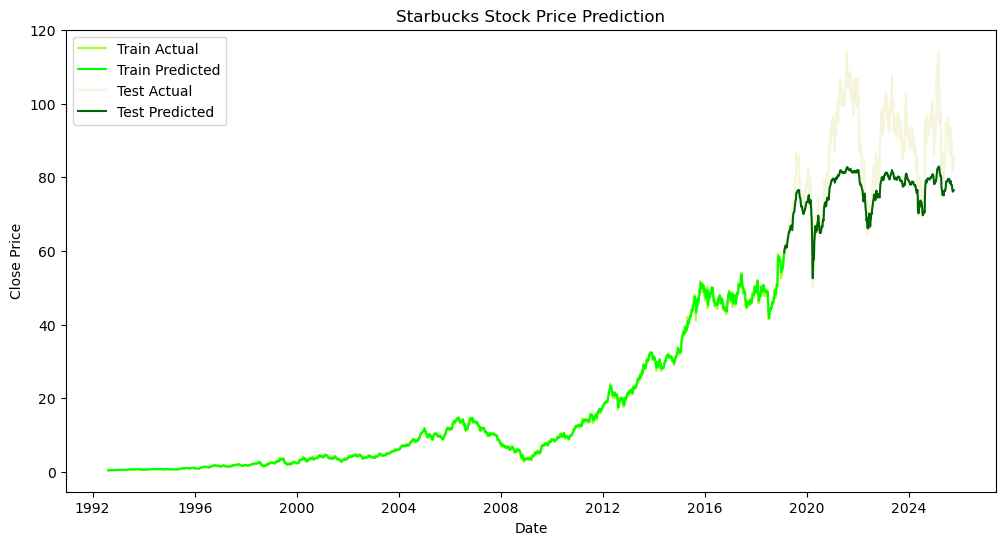

In [21]:
train_dates = df.index[seq_length:seq_length+train_size]
test_dates = df.index[seq_length+train_size:]

plt.figure(figsize=(12,6))
plt.plot(train_dates, y_train_real, label='Train Actual', color='greenyellow')
plt.plot(train_dates, y_train_pred, label='Train Predicted', color='lime')
plt.plot(test_dates, y_test_real, label='Test Actual', color='beige')
plt.plot(test_dates, y_test_pred, label='Test Predicted', color='darkgreen')
plt.title("Starbucks Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [37]:
# Save the Model
torch.save(model.state_dict(), "starbucks_lstm.pth")